### CERN-HSF TASKS : Precision Recovery in Lossy-Compressed Floating Point Data for High Energy Physics

Submitted by : Tanmay Bakshi <br>
Indian Institute of Technology, Roorkee, India <br>
Bachelors' in Technology (Major in Computer Science and Engineering) [Pursuing] <br>


Submitted on - Mar 23, 2025 (11:30 AM IST)


In [270]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import h5py
import sys

from bitarray.util import vl_decode


class NumberGenerator:
    def __init__(self, n_samples = 100000, seed = None, file_pth = None, **kwargs):
        self.n_samples = n_samples
        self.seed = seed
        self.uniform_distribution = None
        self.gaussian_distribution = None
        self.exponential_distribution = None
        self.file_pth = file_pth

        if seed is not None:
            np.random.seed(seed)

    def gen_uniform(self, **kwargs):
        parameters = {'low' : 0.0, 'high' : 1.0}
        parameters.update(kwargs)
        self.uniform_distribution = np.random.uniform(size=(self.n_samples,), **parameters)

    def gen_gaussian(self, **kwargs):
        parameters = {'loc' : 0.0, 'scale' : 1.0}
        parameters.update(kwargs)
        self.gaussian_distribution = np.random.normal(size=(self.n_samples,), **parameters)

    def gen_exponential(self, **kwargs):
        parameters = {'scale' : 1.0}
        parameters.update(kwargs)
        self.exponential_distribution = np.random.exponential(size=(self.n_samples,), **parameters)

    def dist_plotter(self, **kwargs):
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))
        parameters = {'bins': 100, 'density': True, 'alpha': 0.5}
        parameters.update(kwargs)

        # Set the main title for the entire figure
        fig.suptitle(f"Distribution Plots for {self.n_samples} Samples", fontsize=14, fontweight='bold')

        # Uniform Distribution
        axes[0].hist(self.uniform_distribution, color='green', **parameters)
        axes[0].set_title('Uniform Distribution')

        # Gaussian Distribution
        axes[1].hist(self.gaussian_distribution, color='red', **parameters)
        axes[1].set_title('Gaussian Distribution')

        # Exponential Distribution
        axes[2].hist(self.exponential_distribution, color='blue', **parameters)
        axes[2].set_title('Exponential Distribution')

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
        plt.show()

    def save(self):
        with h5py.File(self.file_pth, 'w') as f:
            f.create_dataset('uniform_distribution', data = self.uniform_distribution, dtype = 'float64')
            f.create_dataset('gaussian_distribution', data = self.gaussian_distribution, dtype = 'float64')
            f.create_dataset('exponential_distribution', data = self.exponential_distribution, dtype = 'float64')
        f.close()
        return

    def save_gaussian(self, gaus_pth):
        with h5py.File(gaus_pth, 'w') as f:
            f.create_dataset('gaussian_distribution', data = self.gaussian_distribution, dtype = 'float64')
        f.close()
        return

    def save_uniform(self, unif_pth):
        with h5py.File(unif_pth, 'w') as f:
            f.create_dataset('uniform_distribution', data = self.uniform_distribution, dtype = 'float64')
        f.close()
        return

    def save_exponential(self, exp_pth):
        with h5py.File(exp_pth, 'w') as f:
            f.create_dataset('exponential_distribution', data = self.exponential_distribution, dtype = 'float64')
        f.close()
        return





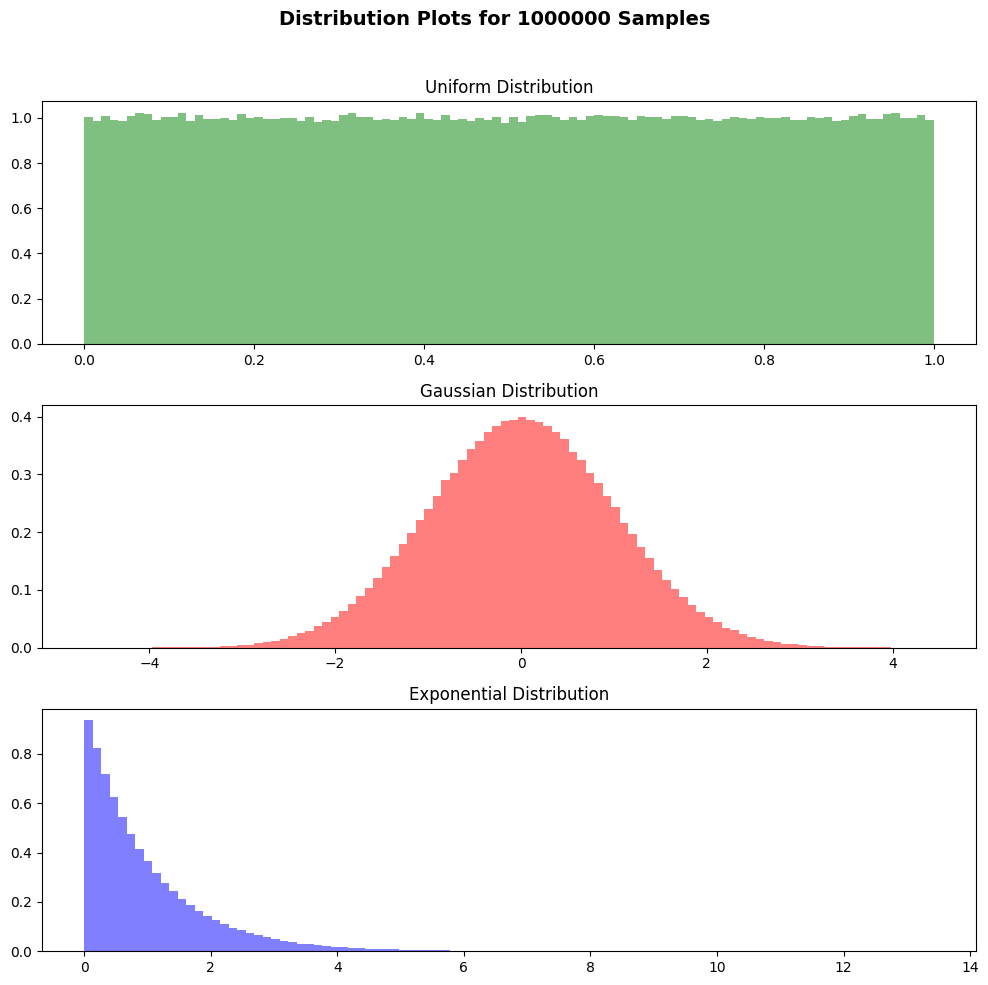

In [271]:
NG = NumberGenerator(n_samples = 1000000, seed=12345, file_pth = 'FP')
NG.gen_uniform()
NG.gen_gaussian()
NG.gen_exponential()
NG.dist_plotter()
NG.save()

In [272]:
uniform_dist = NG.uniform_distribution
gaussian_dist = NG.gaussian_distribution
exponential_dist = NG.exponential_distribution


In [273]:
gaussian_dist.dtype
exponential_dist.dtype

dtype('float64')

sys.getsizeof() returns the size of the list in Bytes.
As we see, an empty list acquires 56 bytes.

In [274]:
lst_empty = []
sys.getsizeof(lst_empty)

print("Size of Uniform Distribution Data (including overhead and references) : ", sys.getsizeof(uniform_dist), " Bytes")
print("Size of Gaussian Distribution Data (including overhead and references) : ", sys.getsizeof(gaussian_dist), " Bytes")
print("Size of Exponential Distribution Data (including overhead and references) : ", sys.getsizeof(exponential_dist), " Bytes")


print("Size (Actual) of Uniform Distribution Data : ", uniform_dist.nbytes, " Bytes")
print("Size (Actual) of Gaussian Distribution Data : ", gaussian_dist.nbytes, " Bytes")
print("Size (Actual) of Exponential Distribution Data : ", exponential_dist.nbytes, " Bytes")

Size of Uniform Distribution Data (including overhead and references) :  8000112  Bytes
Size of Gaussian Distribution Data (including overhead and references) :  8000112  Bytes
Size of Exponential Distribution Data (including overhead and references) :  8000112  Bytes
Size (Actual) of Uniform Distribution Data :  8000000  Bytes
Size (Actual) of Gaussian Distribution Data :  8000000  Bytes
Size (Actual) of Exponential Distribution Data :  8000000  Bytes


In [275]:
print(sys.byteorder)

little



class LossyCompression:
    def __init__(self, file_pth = 'FP', **kwargs):
        self.file_pth = file_pth
        self.raw_data = {}
        self.bit_data = {}
        self.lossy_distribution = {}

        with h5py.File(self.file_pth, 'r') as f:
            self.raw_data['uniform_distribution'] = f['uniform_distribution'][:]
            self.raw_data['gaussian_distribution'] = f['gaussian_distribution'][:]
            self.raw_data['exponential_distribution'] = f['exponential_distribution'][:]
        f.close()

        self.file_statistics(self, self.raw_data)

        print("=====PERFORMING COMPRESSION=====")
        # v_funct = np.vectorize(self.float_to_bits)
        # self.bit_data['uniform_distribution'] = v_funct(self.raw_data['uniform_distribution'])
        # self.bit_data['gaussian_distribution'] = v_funct(self.raw_data['gaussian_distribution'])
        # self.bit_data['exponential_distribution'] = v_funct(self.raw_data['exponential_distribution'])
        self.lossy_compression(n_bits = 16)
        self.file_statistics(self, self.lossy_distribution)



    @staticmethod
    def file_statistics(self, dictionary):
        print("Size of Uniform Distribution Data : ", sys.getsizeof(dictionary['uniform_distribution']), " Bytes")
        print("Size of Gaussian Distribution Data : ", sys.getsizeof(dictionary['gaussian_distribution']), " Bytes")
        print("Size of Exponential Distribution Data : ", sys.getsizeof(dictionary['exponential_distribution']), " Bytes")
        return None

    @staticmethod
    def float_to_bits(self):
        packed = struct.pack('<d', self)
        bitstring = ''.join(f'{byte:08b}' for byte in packed)
        return bitstring

    def bitstring_to_int(self, bitstring):
        """Convert a 64-bit bitstring to an integer."""
        return int(bitstring, 2)

    def int_to_bitstring(self, n):
        """Convert an integer to a 64-bit bitstring."""
        return f'{n:064b}'

    def bitwise_and(self, bitstring1, bitstring2):
        """Perform a bitwise AND operation between two bitstrings."""
        int1 = self.bitstring_to_int(bitstring1)
        int2 = self.bitstring_to_int(bitstring2)
        result_int = int1 & int2
        int_result = self.int_to_bitstring(result_int)
        return self.bitstring_to_float(int_result)

    def bitstring_to_float(self, bitstring):
        """Convert a 64-bit bitstring back to a float."""
        # Split the bitstring into bytes (8 bits each)
        bytes_list = [int(bitstring[i:i+8], 2) for i in range(0, 64, 8)]
        # Pack bytes into a bytes object
        packed = bytes(bytes_list)
        # Unpack bytes into a float
        return struct.unpack('<d', packed)[0]


    def peek_at_data(self, id):
        print(self.raw_data['uniform_distribution'][id])
        print(self.raw_data['gaussian_distribution'][id])

        print(self.lossy_distribution['uniform_distribution'][id])
        print(self.lossy_distribution['gaussian_distribution'][id])
        print("---><---><---><---><---><---><---><---")
        # print(self.raw_data['gaussian_distribution'][id])
        # print(self.bit_data['gaussian_distribution'][id])
        # print("---><---><---><---><---><---><---><---")
        # print(self.raw_data['exponential_distribution'][id])
        # print(self.bit_data['exponential_distribution'][id])
        return None


    def lossy_compression(self, n_bits):

        #Computing the bitmask and packing as a bitstring
        mask = ((1 << 64) - (1 << n_bits))
        # packed_mask = struct.pack('<d', mask)
        packed_bytes = struct.pack('<Q', mask)
        mask_bitstring = ''.join(f'{byte:08b}' for byte in packed_bytes)

        def apply_mask(bitstring):
            return self.bitwise_and(bitstring, mask_bitstring)

        v_funct_mask = np.vectorize(apply_mask)

        # Converting distribution values to bitstrings for further manipulation
        v_funct = np.vectorize(self.float_to_bits)
        for key in self.raw_data:
            self.bit_data[key] = v_funct(self.raw_data[key])
            self.lossy_distribution[key] = v_funct_mask(self.bit_data[key])

        return

In [276]:
def dist_plotter(dictionary, fstring, n_samples, **kwargs):
        fig, axes = plt.subplots(3, 1, figsize=(10, 10))
        parameters = {'bins': 100, 'density': True, 'alpha': 0.5}
        parameters.update(kwargs)

        # Set the main title for the entire figure
        fig.suptitle(f" {fstring} Distribution Plots for {n_samples} Samples", fontsize=14, fontweight='bold')

        # Uniform Distribution
        axes[0].hist(dictionary['uniform_distribution'], color='green', **parameters)
        axes[0].set_title('Uniform Distribution')

        # Gaussian Distribution
        axes[1].hist(dictionary['gaussian_distribution'], color='red', **parameters)
        axes[1].set_title('Gaussian Distribution')

        # Exponential Distribution
        axes[2].hist(dictionary['exponential_distribution'], color='blue', **parameters)
        axes[2].set_title('Exponential Distribution')

        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
        plt.show()
        return None

In [310]:
import random
from bitarray import bitarray

class LossyCompression:
    """ A Class to handle the Lossy Compression Procedure.
        FP.hdf : UNCOMPRESSED, RAW FILE
        Compressed_FP.hdf : COMPRESSED FILE
        n_bits_range : (_, _) a tuple to specify the range for LSB zeroing (Given as 8 to 16)


    """
    def __init__(self, file_pth=None, save_file_pth = None, n_bits = 16):
        self.file_pth = file_pth
        self.save_file_pth = save_file_pth
        self.raw_data = {}
        self.lossy_distribution = {}
        self.decompressed_data = {}
        self.n_bits = n_bits
        # self.mask_val = []


        # Loading data from HDF5 file
        with h5py.File(self.file_pth, 'r') as f:
            for key in ['uniform_distribution', 'gaussian_distribution', 'exponential_distribution']:
                if key in f:
                    self.raw_data[key] = f[key][:]

        f.close()
        # Before Performing Lossy Compression, viewing the
        self.file_statistics(self.raw_data)

        print("===== PERFORMING COMPRESSION =====")
        self.lossy_compression(self.n_bits)
        print("\n===== AFTER COMPRESSION =====")
        # Saving the compressed file
        self.save()
        self.file_statistics(self.lossy_distribution)

        print("\n===== PERFORMING DECOMPRESSION =====")
        self.decompression()

        print("\n===== AFTER DECOMPRESSION =====")
        self.file_statistics(self.decompressed_data)

    @staticmethod
    def file_statistics(dictionary):
        """Print the size of the data in bytes."""
        for key in dictionary:
            print(f"Size of {key} Data: {dictionary[key].nbytes} Bytes")

    @staticmethod
    def float_to_bits(f):
        """Convert a float64 to a 64-bit integer."""
        return struct.unpack('<Q', struct.pack('<d', f))[0]

    @staticmethod
    def bitstring_to_bytes(bs):
        return int(bs, 2).to_bytes((len(bs) + 7 )// 8, byteorder = 'little')

    @staticmethod
    def bits_to_float(bits):
        """Convert a 64-bit integer back to float64."""
        return struct.unpack('<d', struct.pack('<Q', bits))[0]


    def lossy_compression(self, n_bits = 16):
        # Computing the bitmask for each of the data value by zeroing a random number of LSBs in
        # range of 8 to 16.
        # Store the generated number of truncation bits in a list for decoding purposes

        @staticmethod
        def compress_value(x):
            mask = ((1 << 64) - (1 << n_bits))
            # self.mask_val.append(n_bits)
            """Apply the mask to a single floating-point number."""
            bit_rep = self.float_to_bits(x)  # Convert float to bit representation
            # print(" x : ", x, bin(bit_rep))
            # print(" Mask : ", bin(mask))
            # print("Compression side - 1")
            # print(x)
            # print(bit_rep)
            # input()
            masked_bits = bit_rep & mask     # Zero out the n_bits LSBs
            # print("Masked bits", bin(masked_bits))
            truncated_mask = bin(masked_bits)[:-n_bits]

            # print("Truncated Mask : ", truncated_mask)
            # input()
            # print(type(truncated_mask))
            # print(bin(masked_bits))
            # print(sys.getsizeof(truncated_mask))
            bytes = self.bitstring_to_bytes(truncated_mask)

            # print("Bytes : ", bytes)

            # x = bytes.rjust(8, b'\x00')

            # input()
            return bytes # Convert back to float



        # Apply lossy compression and store results
        for key in self.raw_data:
            # print(key)
            v_compress = np.vectorize(compress_value)
            self.lossy_distribution[key] = v_compress(self.raw_data[key])
            # self.lossy_distribution[key] = np.packbits(self.lossy_distribution[key])

    def decompression(self):

        @staticmethod
        def decompress_value(x):
            # print("Decompression side - 1")
            # print(x)
            # input()
            if len(x) < 8:
                x = x.rjust(8, b'\x00')
                # print("y : ")
                # print(y)
                # print(struct.unpack('<d', y)[0])
                # print("z : ")
                # print(z)
                # print(struct.unpack('<d', z)[0])
                # return struct.unpack('<d', y)[0]
            a = struct.unpack('<d', x)[0]
            # print(struct.unpack('<Q', x)[0])
            # input()
            # print(struct.unpack('<d', x)[0])
            # input()
            return a

        with h5py.File(self.save_file_pth, 'w') as f:
            for key, value in self.lossy_distribution.items():
                f.create_dataset(key, data=value)
        f.close()

        v_decompress = np.vectorize(decompress_value)
        for key in self.lossy_distribution:
            # print(key)
            # input()
            self.decompressed_data[key] = v_decompress(self.lossy_distribution[key])

        return None


    def save(self):
        with h5py.File(self.save_file_pth, 'w') as f:
            for key in ['uniform_distribution', 'gaussian_distribution', 'exponential_distribution']:
                if key in self.lossy_distribution:  # Only save if present
                    f.create_dataset(key, data=self.lossy_distribution[key])
        f.close()
        print("Success")

    def peek_at_data(self, id):
        print(self.raw_data['uniform_distribution'][id])
        print(self.raw_data['gaussian_distribution'][id])

        print(self.lossy_distribution['uniform_distribution'][id])
        print(self.lossy_distribution['gaussian_distribution'][id])
        print("---><---><---><---><---><---><---><---")
        # print(self.raw_data['gaussian_distribution'][id])
        # print(self.bit_data['gaussian_distribution'][id])
        # print("---><---><---><---><---><---><---><---")
        # print(self.raw_data['exponential_distribution'][id])
        # print(self.bit_data['exponential_distribution'][id])
        return None

    def get_distributions(self):
        return self.raw_data, self.decompressed_data



In [311]:
import scipy.stats as stats
import pandas as pd
def compare_distributions(dist1, dist2):
    """
    Compare statistical parameters (mean, variance, skewness, kurtosis) of two distributions
    and compute the mean squared error (MSE) between them.

    Parameters:
        dist1 (list): Samples from the first distribution
        dist2 (list): Samples from the second distribution

    Returns:
        dict: Statistical comparison and MSE
    """
    # Convert lists to numpy arrays
    dist1 = np.array(dist1)
    dist2 = np.array(dist2)

    # Compute statistical parameters
    stats1 = {
        'mean': np.mean(dist1),
        'variance': np.var(dist1, ddof=1),
        'skewness': stats.skew(dist1),
        'kurtosis': stats.kurtosis(dist1)
    }

    stats2 = {
        'mean': np.mean(dist2),
        'variance': np.var(dist2, ddof=1),
        'skewness': stats.skew(dist2),
        'kurtosis': stats.kurtosis(dist2)
    }

    # Compute Mean Squared Error (MSE)
    min_len = min(len(dist1), len(dist2))
    mse = np.mean((dist1[:min_len] - dist2[:min_len]) ** 2)

    return {
        'Original Data': stats1,
        'Decompressed Data': stats2,
        'mean_squared_error': mse
    }


def display_results(result, title):
    """
    Display statistical comparison results in a table format.
    """
    df = pd.DataFrame(result).T
    print(f"\n{title}")
    print(df.to_string())

From Wikipedia :

The 53-bit significand precision gives from 15 to 17 significant decimal digits precision (2−53 ≈ 1.11 × 10−16). If a decimal string with at most 15 significant digits is converted to the IEEE 754 double-precision format, giving a normal number, and then converted back to a decimal string with the same number of digits, the final result should match the original string. If an IEEE 754 double-precision number is converted to a decimal string with at least 17 significant digits, and then converted back to double-precision representation, the final result must match the original number.

### CASE - 1: For 16 BITS BEING REDUCED

Here, I see that as for fixed number of `n_samples`, the Uniform Distribution achieves the most compression (greater than the other 2 distributions). Also, as I increase `n_samples`, the compressibility of Gaussian and Normal Distributions decreases. For high number of samples, almost no compression is seen.

Let's see 3 sample sizes :

(i) 10,000 samples <br>
(ii) 100,000 samples <br>
(iii) 1,000,000 samples

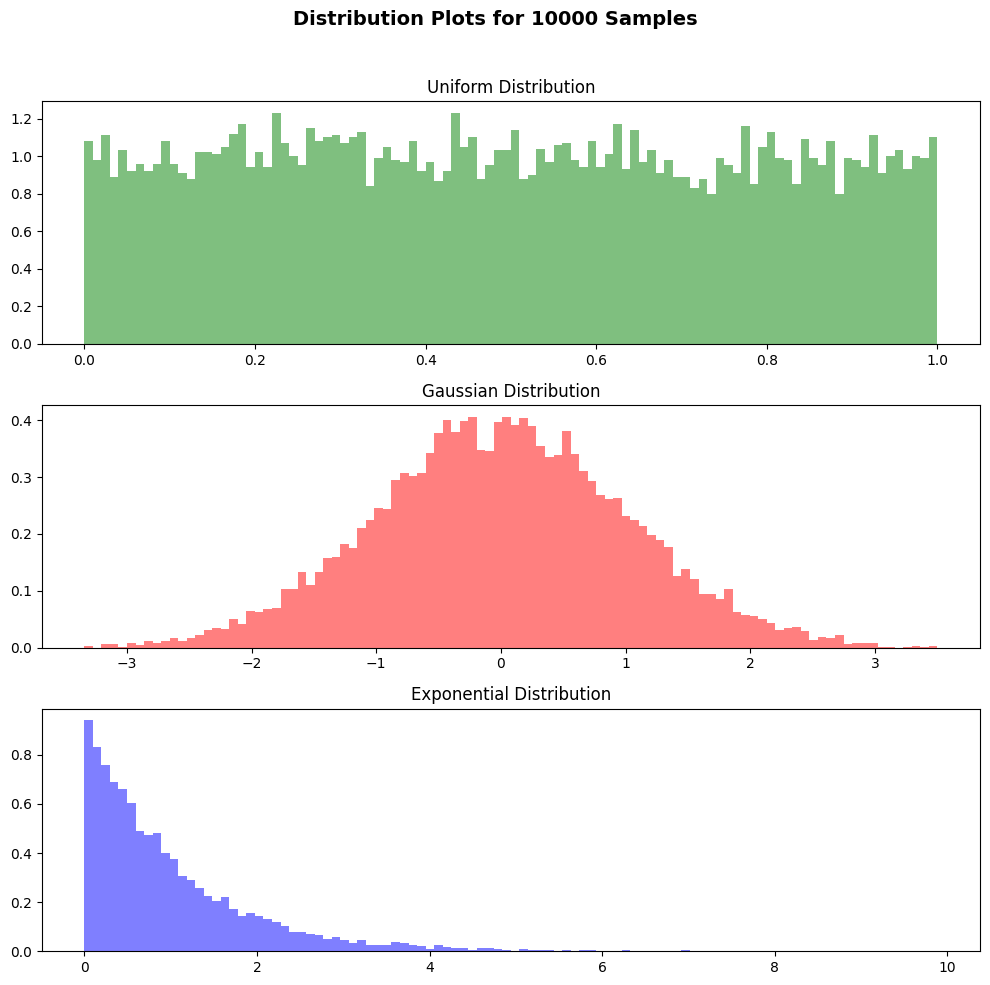

In [312]:
NG = NumberGenerator(n_samples = 10000, seed=1197, file_pth="FP_10k")
NG.gen_uniform()
NG.gen_gaussian()
NG.gen_exponential()
NG.dist_plotter()
NG.save()

In [313]:
LC = LossyCompression(file_pth = 'FP_10k', save_file_pth = 'comp_10k', n_bits = 16)

original_dict, decompressed_dict = LC.get_distributions()

Size of uniform_distribution Data: 80000 Bytes
Size of gaussian_distribution Data: 80000 Bytes
Size of exponential_distribution Data: 80000 Bytes
===== PERFORMING COMPRESSION =====

===== AFTER COMPRESSION =====
Success
Size of uniform_distribution Data: 60000 Bytes
Size of gaussian_distribution Data: 70000 Bytes
Size of exponential_distribution Data: 70000 Bytes

===== PERFORMING DECOMPRESSION =====

===== AFTER DECOMPRESSION =====
Size of uniform_distribution Data: 80000 Bytes
Size of gaussian_distribution Data: 80000 Bytes
Size of exponential_distribution Data: 80000 Bytes


In [314]:
uniform_dist[0]

0.9296160928171479

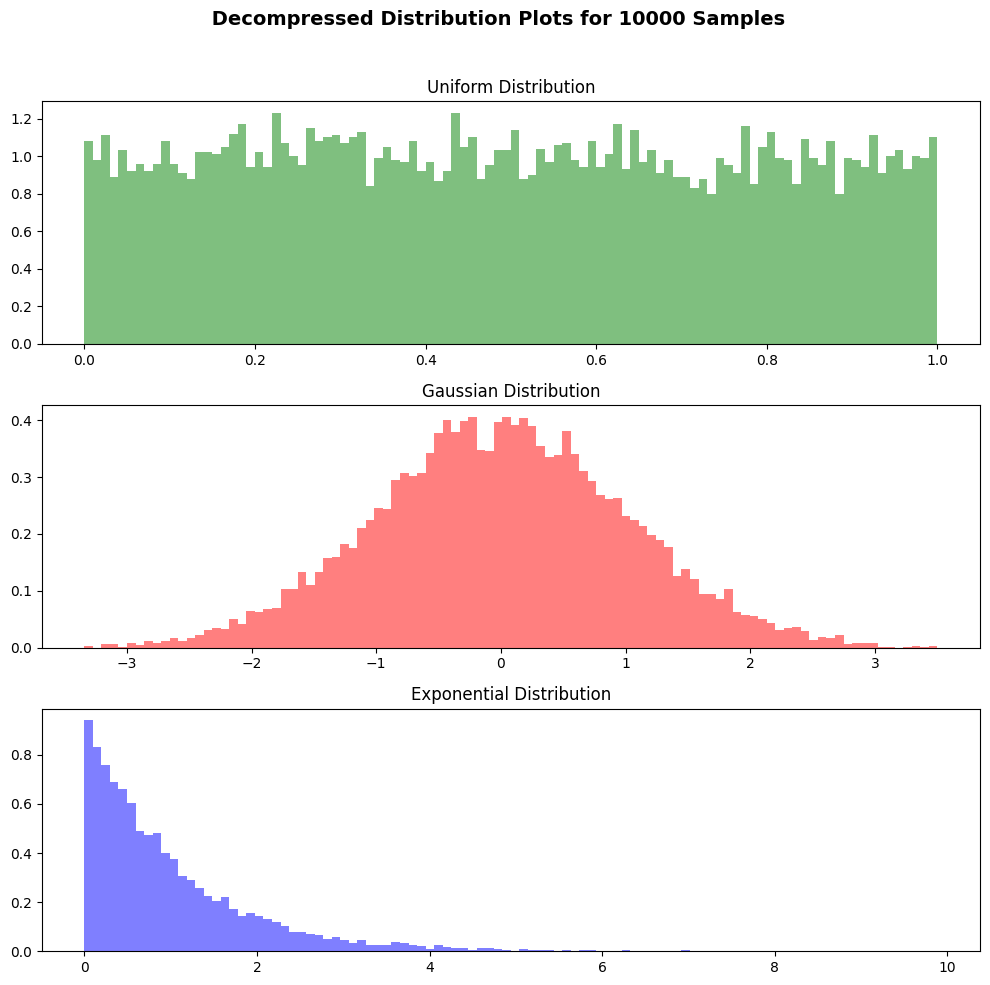

In [315]:
dist_plotter(decompressed_dict, fstring='Decompressed', n_samples=10000)

In [316]:
result_uniform = compare_distributions(original_dict['uniform_distribution'], decompressed_dict['uniform_distribution'])
result_gaussian = compare_distributions(original_dict['gaussian_distribution'], decompressed_dict['gaussian_distribution'])
result_exponential = compare_distributions(original_dict['exponential_distribution'], decompressed_dict['exponential_distribution'])

display_results(result_uniform, "Uniform Distribution Comparison")
display_results(result_gaussian, "Gaussian Distribution Comparison")
display_results(result_exponential, "Exponential Distribution Comparison")



Uniform Distribution Comparison
                            mean      variance      skewness      kurtosis
Original Data       4.960425e-01  8.299979e-02  3.193432e-02 -1.192261e+00
Decompressed Data   4.960425e-01  8.299979e-02  3.193432e-02 -1.192261e+00
mean_squared_error  1.023302e-23  1.023302e-23  1.023302e-23  1.023302e-23

Gaussian Distribution Comparison
                            mean      variance      skewness      kurtosis
Original Data       3.761574e-03  1.031270e+00  2.541031e-02 -4.949153e-02
Decompressed Data   3.761574e-03  1.031270e+00  2.541031e-02 -4.949153e-02
mean_squared_error  3.917849e-23  3.917849e-23  3.917849e-23  3.917849e-23

Exponential Distribution Comparison
                            mean      variance      skewness      kurtosis
Original Data       1.013123e+00  1.039595e+00  2.103100e+00  6.821946e+00
Decompressed Data   1.013123e+00  1.039595e+00  2.103100e+00  6.821946e+00
mean_squared_error  7.983021e-23  7.983021e-23  7.983021e-23  7.983021e

In [317]:
# a = "11111111101100110011001101101011100000101111110000000000000000"
#
# b = int(a, 2).to_bytes(8, byteorder='little')
# b
# s = "1111111110110011001100110110101110000010111111"
# # d is what is getting saved to the COMPRESSED DATA.
# # When we read it, we need to add appropriate number of 0s in the lead (little-endian)
# d = int(s, 2).to_bytes((len(s)+7)//8, byteorder='little')
# d
# len(d)
# f = d.rjust(8, b'\x00')
# f
# c = struct.unpack('<d', f)[0]
# c

### On-disk sizes

In [318]:
!du -sh comp_10k

200K	comp_10k


In [319]:
!du -sh FP_10k

240K	FP_10k


#### (II) 100,000 samples

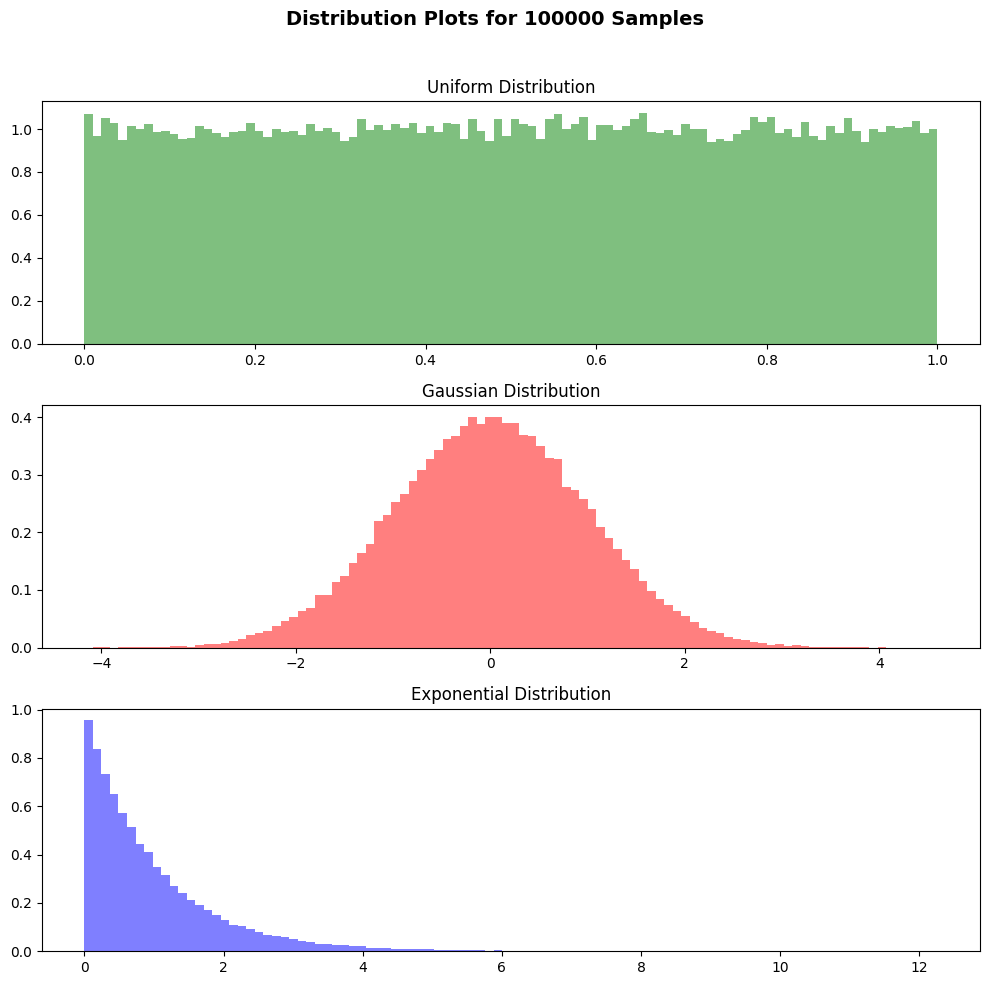

In [320]:
NG = NumberGenerator(n_samples = 100000, seed=1197, file_pth="FP_100k")
NG.gen_uniform()
NG.gen_gaussian()
NG.gen_exponential()
NG.dist_plotter()
NG.save()

In [321]:
LC = LossyCompression(file_pth = 'FP_100k', save_file_pth= 'comp_100k', n_bits = 16)

original_dict, decompressed_dict = LC.get_distributions()

Size of uniform_distribution Data: 800000 Bytes
Size of gaussian_distribution Data: 800000 Bytes
Size of exponential_distribution Data: 800000 Bytes
===== PERFORMING COMPRESSION =====

===== AFTER COMPRESSION =====
Success
Size of uniform_distribution Data: 600000 Bytes
Size of gaussian_distribution Data: 700000 Bytes
Size of exponential_distribution Data: 700000 Bytes

===== PERFORMING DECOMPRESSION =====

===== AFTER DECOMPRESSION =====
Size of uniform_distribution Data: 800000 Bytes
Size of gaussian_distribution Data: 800000 Bytes
Size of exponential_distribution Data: 800000 Bytes


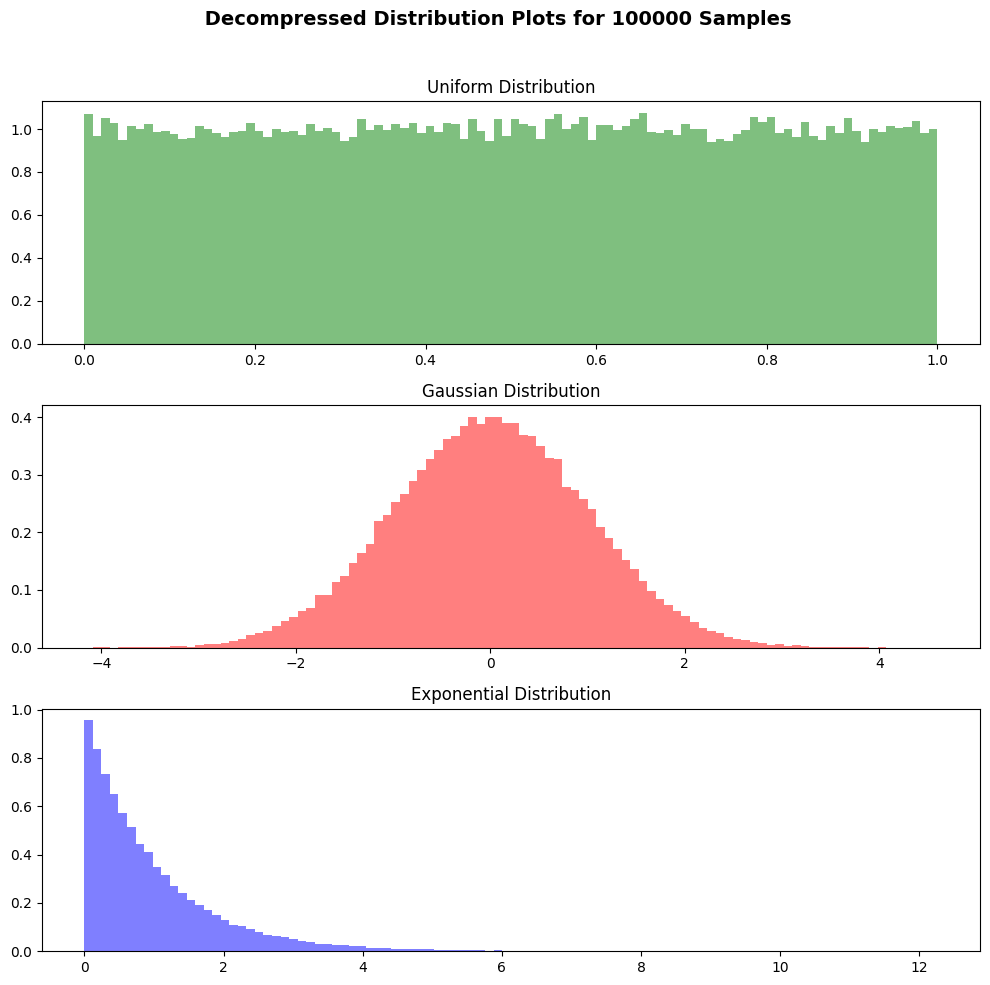

In [322]:
dist_plotter(decompressed_dict, fstring='Decompressed', n_samples=100000)

In [323]:
result_uniform = compare_distributions(original_dict['uniform_distribution'], decompressed_dict['uniform_distribution'])
result_gaussian = compare_distributions(original_dict['gaussian_distribution'], decompressed_dict['gaussian_distribution'])
result_exponential = compare_distributions(original_dict['exponential_distribution'], decompressed_dict['exponential_distribution'])

display_results(result_uniform, "Uniform Distribution Comparison")
display_results(result_gaussian, "Gaussian Distribution Comparison")
display_results(result_exponential, "Exponential Distribution Comparison")



Uniform Distribution Comparison
                            mean      variance      skewness      kurtosis
Original Data       5.002912e-01  8.315815e-02 -3.688716e-03 -1.191761e+00
Decompressed Data   5.002912e-01  8.315815e-02 -3.688716e-03 -1.191761e+00
mean_squared_error  1.021652e-23  1.021652e-23  1.021652e-23  1.021652e-23

Gaussian Distribution Comparison
                            mean      variance      skewness      kurtosis
Original Data      -6.016121e-04  9.991953e-01 -1.311447e-03 -8.476623e-03
Decompressed Data  -6.016121e-04  9.991953e-01 -1.311447e-03 -8.476623e-03
mean_squared_error  3.874276e-23  3.874276e-23  3.874276e-23  3.874276e-23

Exponential Distribution Comparison
                            mean      variance      skewness      kurtosis
Original Data       9.969118e-01  1.004411e+00  2.040891e+00  6.431783e+00
Decompressed Data   9.969118e-01  1.004411e+00  2.040891e+00  6.431783e+00
mean_squared_error  7.667315e-23  7.667315e-23  7.667315e-23  7.667315e

In [324]:
!du -sh comp_100k

2.2M	comp_100k


In [325]:
!du -sh FP_100k

2.5M	FP_100k


#### (III) 1,000,000 samples

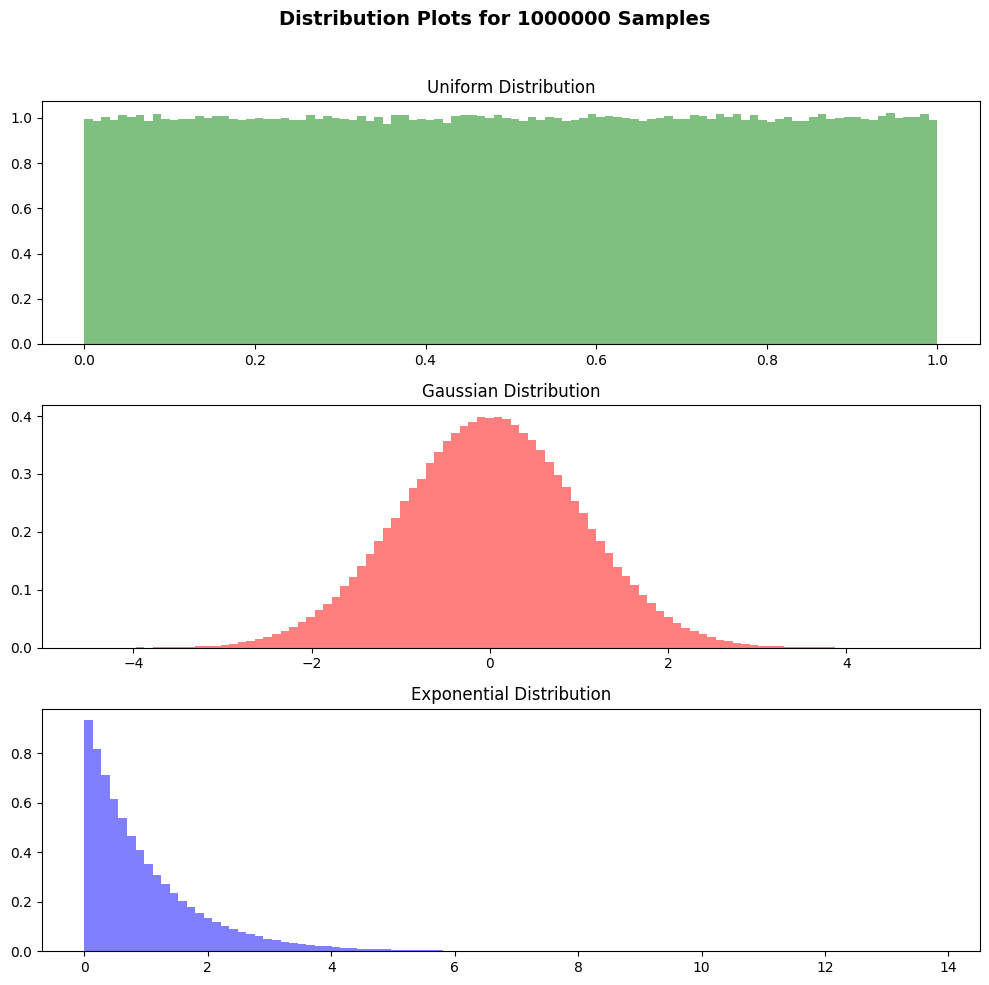

In [326]:
NG = NumberGenerator(n_samples = 1000000, seed=445, file_pth="FP_1M")
NG.gen_uniform()
NG.gen_gaussian()
NG.gen_exponential()
NG.dist_plotter()
NG.save()

In [327]:
LC = LossyCompression(file_pth = 'FP_1M', save_file_pth= 'comp_1M', n_bits = 16)

original_dict, decompressed_dict = LC.get_distributions()

Size of uniform_distribution Data: 8000000 Bytes
Size of gaussian_distribution Data: 8000000 Bytes
Size of exponential_distribution Data: 8000000 Bytes
===== PERFORMING COMPRESSION =====

===== AFTER COMPRESSION =====
Success
Size of uniform_distribution Data: 6000000 Bytes
Size of gaussian_distribution Data: 7000000 Bytes
Size of exponential_distribution Data: 7000000 Bytes

===== PERFORMING DECOMPRESSION =====

===== AFTER DECOMPRESSION =====
Size of uniform_distribution Data: 8000000 Bytes
Size of gaussian_distribution Data: 8000000 Bytes
Size of exponential_distribution Data: 8000000 Bytes


### ON-DISK SIZES OF 1M samples :

In [328]:
!du -sh comp_1M

 19M	comp_1M


In [329]:
!du -sh FP_1M

 23M	FP_1M


## OPTIMAL COMPRESSION LEVELS and THE HIGH-LUMINOSITY PHASE AT CERN

Via the derivations of results and rules within the domain of "Compressive Computing", under very general conditions, it is postulated that 70-80% of the bits used in modern numerical computations are irrelevant for the accuracy of the results. This theory also provides the mechanism to determine the number of bits that can be used to represent numbers without affecting the substance/information carried by the data into the end results.

Another point of emphasis is that, data movement is a considerable bottleneck. We have extremely fast systems that compute results faster than they can be stored or moved. We need techniques with an objective function of reducing the amount of data transfer.

Also, at a place such as CERN, with its CMS and ATLAS experiments, producing giant datastreams through an intricate system of sensors, we are running ML algorithms on FPGA level to reject data. Despite this aggressive filtering, we need more aggressive "Lossy Compression Algorithms" that do not lose any "physics" down the analysis pipeline. I know that we are interested in data lying Beyond the Standard Model (BSM), and previously unseen data must be retained in its originality. The compression algorithm must preserve this valuable data to the highest possible precision allowed by the physical devices in the pipeline.

To define an optimal compression limit in the use-cases of HEP at CERN, I would look to fulfill these criteria. :

* Pointwise error might not be a good metric, since the resolution of various instruments at different levels varies. So, to measure correctness, we can look into preserving "Higher Order Information" within the data distributions.

We are essentially, "teleporting" a collective essence of the data distribution for storage purposes and retrieving the core aspects via well-founded bases. When I think of the problem at hand, I think of the manifolds that are constructed by a given analysis method - in our case, a Neural Network acting on a given dataset. Such a manifold, in essence, would be a non-linear mapping from the datastream taken up for analysis (which we shall model as random variables). Now, I believe, the problem has been boiled down to preserving certain characteristic features of the manifold - including topology, invariance etc.
There is also an interesting body of research that uses ANNs (Neural Networks) as Manifold compressors. This aligns highly with my prior experience as a research intern where I studied Double-Framed Moduli spaces - existence of low-dimensional manifolds (what's "relevant") in high-dimensional spaces (raw, uncompressed data).

* Within this notion of preserving topological invariants within data, we can define a target threshold ( a form of an upper bound ) that tells to what extent and to what scale are the topological features preserved when we compress the data.

* Moreover, rather than using localized methods such as clustering to group similar datapoints, a Topological approach ensures preservation of the "global picture", which can be promising considering the manifold-inspired picture of viewing data distributions lying in higher dimensions.

In this regard, some resources I intend to study in greater detail are : <br>


[Topologically Controlled Lossy Compression](https://julien-tierny.github.io/stuff/papers/soler_pv18.pdf)  <br>
[Lossy compression of General Random Variables](https://arxiv.org/abs/2111.12312)  <br>
[Do Neural Networks Compress Manifolds Optimally?](https://arxiv.org/abs/2205.08518)  <br>

<img src = "topo_img.png" alt = "Image from Topologically Controlled Lossy Compression" width = "800"/>










Size of gaussian_distribution Data: 800000 Bytes
===== PERFORMING COMPRESSION =====

===== AFTER COMPRESSION =====
Success
Size of gaussian_distribution Data: 500000 Bytes

===== PERFORMING DECOMPRESSION =====

===== AFTER DECOMPRESSION =====
Size of gaussian_distribution Data: 800000 Bytes
Mean: -10.0, Variance: 0.5 -> Compression Ratio: 0.6260
Size of gaussian_distribution Data: 800000 Bytes
===== PERFORMING COMPRESSION =====

===== AFTER COMPRESSION =====
Success
Size of gaussian_distribution Data: 500000 Bytes

===== PERFORMING DECOMPRESSION =====

===== AFTER DECOMPRESSION =====
Size of gaussian_distribution Data: 800000 Bytes
Mean: -10.0, Variance: 111.55555555555556 -> Compression Ratio: 0.6260
Size of gaussian_distribution Data: 800000 Bytes
===== PERFORMING COMPRESSION =====

===== AFTER COMPRESSION =====
Success
Size of gaussian_distribution Data: 500000 Bytes

===== PERFORMING DECOMPRESSION =====

===== AFTER DECOMPRESSION =====
Size of gaussian_distribution Data: 800000 Byt

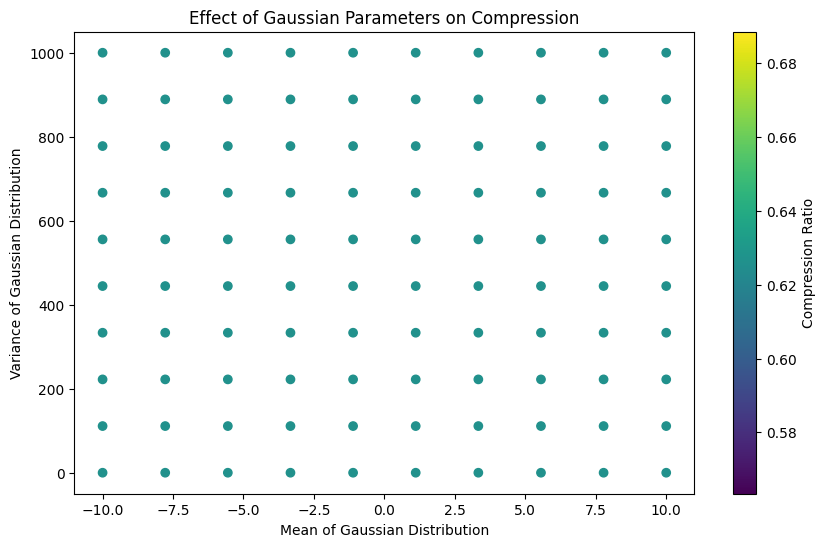

In [330]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

# Assuming NumberGenerator and LossyCompression classes are already defined

def run_experiment_gaussian(mean_values, variance_values, n_samples=100000, seed=42):
    results = []

    for mean in mean_values:
        for var in variance_values:
            # Generate distributions
            file_pth = f"gaussian_{mean}_{var}.hdf5"
            save_file_pth = f"compressed_gaussian_{mean}_{var}.hdf5"

            generator = NumberGenerator(n_samples=n_samples, seed=seed, file_pth=file_pth)
            generator.gen_gaussian(loc=mean, scale=np.sqrt(var))  # variance = scale^2
            generator.save_gaussian(gaus_pth=file_pth)

            # Apply Lossy Compression
            compressor = LossyCompression(file_pth=file_pth, save_file_pth=save_file_pth, n_bits = 32)

            # Measure file sizes
            original_size = os.path.getsize(file_pth)
            compressed_size = os.path.getsize(save_file_pth)
            compression_ratio = compressed_size / original_size

            print(f"Mean: {mean}, Variance: {var} -> Compression Ratio: {compression_ratio:.4f}")
            results.append((mean, var, compression_ratio))

    return results


def plot_results(results):
    means, vars, ratios = zip(*results)

    plt.figure(figsize=(10, 6))
    plt.scatter(means, vars, c=ratios, cmap='viridis', marker='o')
    plt.colorbar(label='Compression Ratio')
    plt.xlabel("Mean of Gaussian Distribution")
    plt.ylabel("Variance of Gaussian Distribution")
    plt.title("Effect of Gaussian Parameters on Compression")
    plt.show()

# Define parameter ranges
mean_values = np.linspace(-10, 10, 10)
variance_values = np.linspace(0.5, 1000, 10)

# Run experiments and visualize
results = run_experiment_gaussian(mean_values, variance_values)
plot_results(results)


In [29]:
LC.peek_at_data(id=5)

0.5955447029792516
b'\xecB\xd3\xc3\xb3\x0e\xe3?'
---><---><---><---><---><---><---><---
-0.2276661449356789
b'\x87\xdbs\x0b*$\xcd\xbf'
---><---><---><---><---><---><---><---
4.597405651585591
b'\xd2\x05\xa0N\xbec\x12@'


In [50]:
# a = uniform_dist[1] #float64, must occupy 8 bytes
# print(a.dtype)
# print("Size of a's value : ", a.nbytes)
# print("Size of a - ", sys.getsizeof(a)) # Will include the storage overhead induced by the array from which we are indexing it.


float64
8
Size of a -  32


In [44]:
# b = struct.pack('d', a)
# sys.getsizeof(b)

In [54]:
# c = np.array(list(b))
# print(c)

[ 68 176  11  65 127  63 212  63]


In [206]:
# import random
#
# def float_to_bits(self):
#     return struct.pack('<d', self)
#
# def bits_to_float(self):
#     return struct.unpack('<d', self)[0]
#
# def lossy_compression(value):
#     print("Value", value)
#     bits = float_to_bits(value)
#     print("bits : ", bits)
#
#     # int_value = struct.unpack('<d', bits)[0]
#     mask_bits = random.randint(8, 16) # Randomly choose between 8 and 16 bits to zero out
#     # print(sys.getsizeof(bits))
#     # print(sys.getsizeof(mask_bits))
#     # print("Chosen number of decimal places : ", mask_bits)
#     mask = ((1 << 64) - (1 << 8))
#
#     print("Mask statistics :")
#     print(bin(mask))
#
#     # print(bin(bits))
#
#     # # mask_list = [(bin(mask)[i:i+8]) for i in range(0, 64, 8)]
#     # # print(mask_list)
#     packed_bytes = struct.pack('<Q', mask)
#     print(packed_bytes)
#
#     bitstring_mask = ''.join(f'{byte:08b}' for byte in packed_bytes)
#     bs_mask = int(bitstring_mask, 2)
#
#     bitstring_value = ''.join(f'{byte:08b}' for byte in bits)
#     bs_value = int(bitstring_value, 2)
#
#     answer = bs_value & bs_mask
#
#     # answer = bitstring_mask & bitstring_value
#     #
#     # bytes_list = [int(answer[i:i+8], 2) for i in range(0, 64, 8)]
#     # # Pack bytes into a bytes object
#     # packed = bytes(bytes_list)
#     # # Unpack bytes into a float
#     # answer = struct.unpack('<d', packed)[0]
#     #
#     # print(answer)
#
#     # int_A = int.from_bytes(bits)
#     # int_B = int.from_bytes(packed_bytes)
#     #
#     # int_result = int_A & int_B
#     # result_bytes = int_result.to_bytes(8, byteorder='little')
#     #
#     # print(result_bytes)
#     #
#     # final = struct.unpack('<d', result_bytes)[0]
#     # print(final)